In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 23.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal
from scipy.fft import fftshift
import math
import mne

In [ ]:
if 'google.colab' in str(get_ipython()):
 os.chdir('/content/drive/MyDrive/Colab Notebooks/EEG_SHCEEEZ-DL')

base_dir = os.getcwd()
print(f'current directory: {base_dir}')

dataset_dir = os.path.join(base_dir, 'datasets')
print(f'datasets directory: {dataset_dir}')

current directory: /content/drive/MyDrive/Colab Notebooks/EEG_SHCEEEZ-DL
datasets directory: /content/drive/MyDrive/Colab Notebooks/EEG_SHCEEEZ-DL/datasets


####**Utility plotting functions**

In [ ]:
def read_A_dataset(path, case_str):
  case_path = os.path.join(path, case_str)
  subjects_list = []
  for filename in os.listdir(case_path):
    with open(os.path.join(case_path, filename), 'r') as f:
      lines = f.readlines()
      subjects_list.append(lines)
  return subjects_list

# -----------------------------------------
def convert_to_numbers(sub_list):
  new_list = []
  for sub in sub_list:
    new_list.append([float(value) for value in sub])
  return new_list

# -----------------------------------------
def list_segments(lst, segments=16):
  arr = np.array(lst)
  return np.array_split(np.array(arr), segments)


# --------------------------------------------
def divide_to_channels(subjects_list, segments=16):
  return [list_segments(subject, segments) for subject in subjects_list]


# ----------------------------------------------
def log_data_shapes(sch, norm):
  return {
 'sch': (len(sch), len(sch[0]), sch[0][0].shape),
 'norm': (len(norm), len(norm[0]), norm[0][0].shape)}

# --------------------------------------------------
def divide_time_segments(subject_list, time_window=5):
  n_segments = total_time // time_window
  return [np.split(channel, n_segments) for channel in subject_list]


# -----------------------------------------------
def create_spectrogram_data(subject_list):
  new_subject_list = []
  for subject in subject_list:
    specs = []
    segment_channels = divide_time_segments(subject)
    array_of_arrays = np.array([np.array(channel) for channel in segment_channels])
    for i in range(0, array_of_arrays.shape[1]):
      spec_data = np.squeeze(array_of_arrays[:, i, :].reshape((1, -1)))
      specs.append(spec_data)
    new_subject_list.append(specs)
  return new_subject_list


In [ ]:
colors = ['black', 'darkorange', 'blue', 'red', 'cyan', 'limegreen', 'dodgerblue', 'violet', 'slateblue', 'yellow',
          'black', 'darkorange', 'blue', 'red', 'cyan', 'limegreen', 'dodgerblue', 'violet', 'slateblue', 'yellow']

channels_16 = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4',
               'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']

def plot_signals(data, subject_index=0, n_channels=16):
  fig = plt.figure(figsize=(20, 10), dpi=85)
  gs = gridspec.GridSpec(n_channels, 1)

  for i in range(0, n_channels):
    ax = plt.subplot(gs[i])
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    line, = ax.plot(data[subject_index][i], color=colors[i])
    ax.set_yticklabels([])
    ax.set_ylabel(f'{channels_16[i]}')
    plt.xlim([0, recording_len])

  # remove vertical gap between subplots
  plt.subplots_adjust(hspace=.0)
  plt.show()



def create_spectrogram(data, fs, impath= '', save=False):
  plt.specgram(data, Fs=fs, NFFT=1024)
  if save:
    plt.axis('off')
    plt.savefig(impath, dpi=300, pad_inches=0.0, transparent=True, bbox_inches='tight')
  else: plt.show()

In [ ]:
recording_len = 7680
freq = 128
total_time = recording_len // freq
print(f'the recording is {total_time} seconds long and has total {recording_len} values')


norm_raw_data = convert_to_numbers(read_A_dataset(os.path.join(dataset_dir, 'A'), 'norm'))
sch_raw_data = convert_to_numbers(read_A_dataset(os.path.join(dataset_dir, 'A'), 'sch'))
print(f'no. subjects = norm: {len(norm_raw_data)}, sch:{len(sch_raw_data)}')

the recording is 60 seconds long and has total 7680 values
no. subjects = norm: 39, sch:45


In [ ]:
sch_channels = divide_to_channels(sch_raw_data)
norm_channels = divide_to_channels(norm_raw_data)

print('shapes: ', log_data_shapes(sch_channels, norm_channels))

norm_data = norm_channels
sch_data = sch_channels

norm_specgram_data = create_spectrogram_data(norm_data)
sch_specgram_data = create_spectrogram_data(sch_data)

print('\nspectrogram data shapes: ',log_data_shapes(sch_specgram_data, norm_specgram_data))

shapes:  {'sch': (45, 16, (7680,)), 'norm': (39, 16, (7680,))}

spectrogram data shapes:  {'sch': (45, 12, (10240,)), 'norm': (39, 12, (10240,))}



16 channel plot of one schizophernic subject


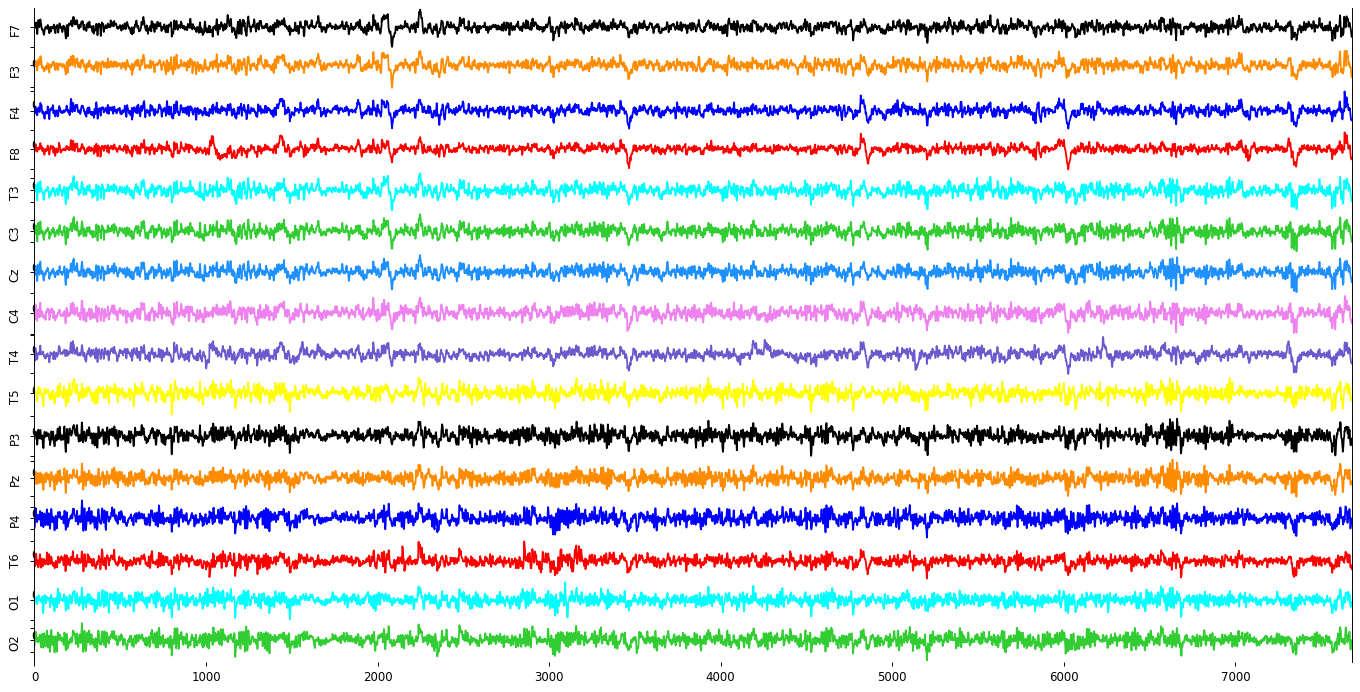

In [ ]:
print("\n16 channel plot of one schizophernic subject")
plot_signals(sch_data, 0)


16 channel plot of one healthy subject 


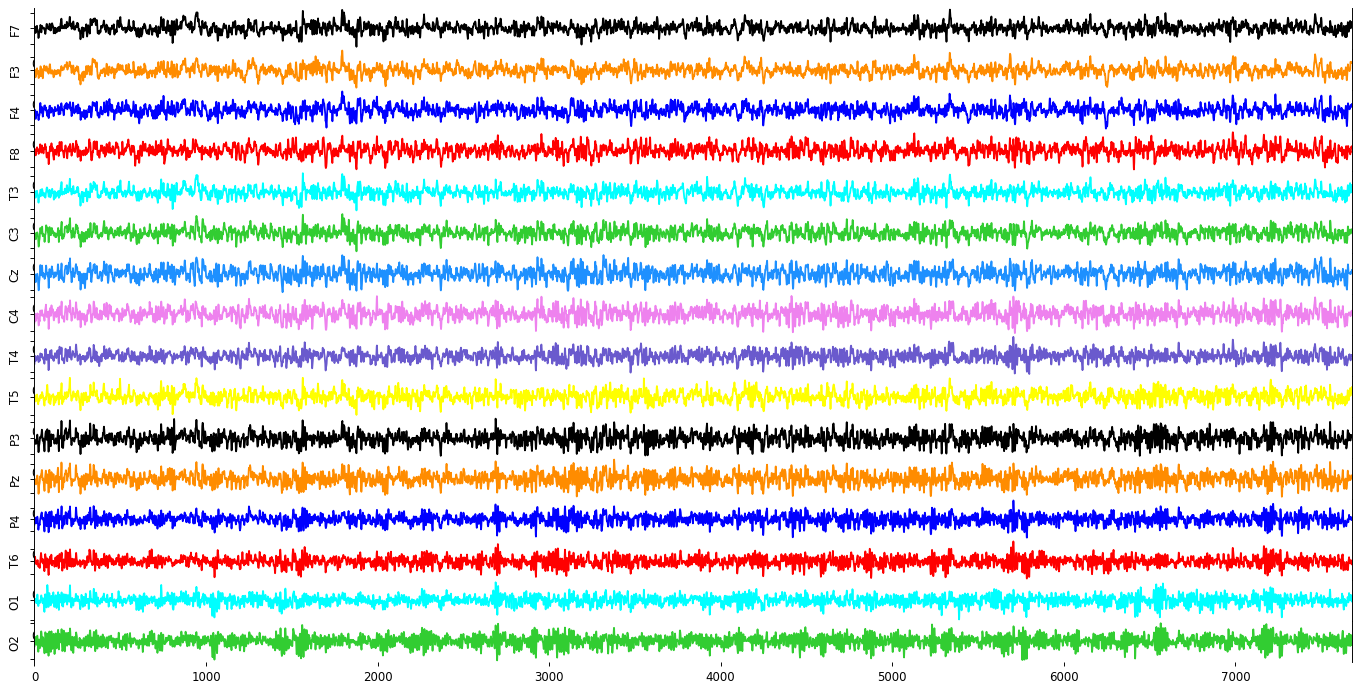

In [ ]:
print("\n16 channel plot of one healthy subject ")
plot_signals(norm_data, 2)

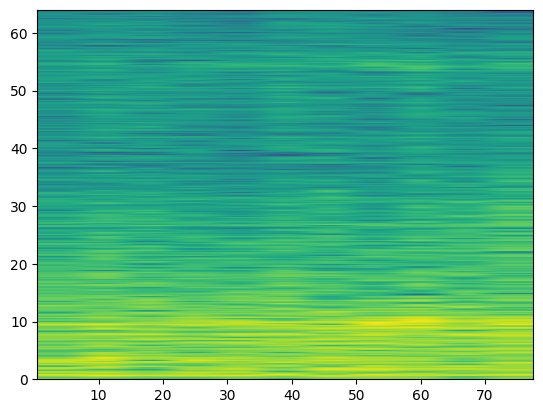

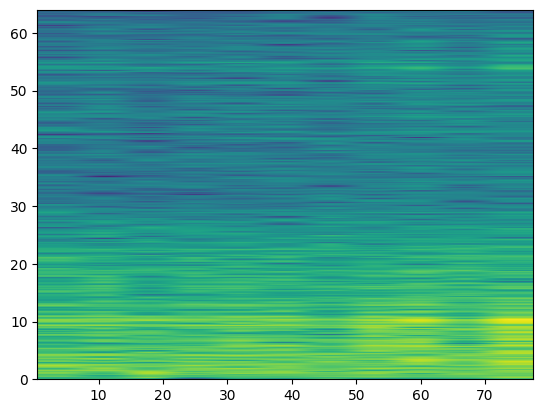

In [ ]:
create_spectrogram(sch_specgram_data[0][0], fs=freq)
create_spectrogram(norm_specgram_data[0][0], fs=freq)

In [ ]:
cwd = os.getcwd()
print(cwd)

def generate_images_for_subject(path, subject_data, sub_index):
  for i, segment in enumerate(subject_data):
    filename = f'sub{sub_index}-seg{i}'
    print('generated: ', filename)
    create_spectrogram(segment, fs=freq, impath=os.path.join(path, filename), save=True)


def generate_images(data, path, start=0, end=0):
  if(end == 0 or end > len(data)):
    end = len(data)
  if not os.path.exists(os.path.join(cwd, path)):
    os.mkdir(path)
  for i in range(start, end):
    generate_images_for_subject(path, data[i], i)


/content/drive/MyDrive/Colab Notebooks/EEG_SHCEEEZ-DL


In [ ]:
images_path_a = os.path.join('out', 'A')

generated:  sub10-seg0
generated:  sub10-seg1
generated:  sub10-seg2
generated:  sub10-seg3
generated:  sub10-seg4
generated:  sub10-seg5
generated:  sub10-seg6
generated:  sub10-seg7
generated:  sub10-seg8
generated:  sub10-seg9
generated:  sub10-seg10
generated:  sub10-seg11
generated:  sub11-seg0
generated:  sub11-seg1
generated:  sub11-seg2
generated:  sub11-seg3
generated:  sub11-seg4
generated:  sub11-seg5
generated:  sub11-seg6
generated:  sub11-seg7
generated:  sub11-seg8
generated:  sub11-seg9
generated:  sub11-seg10
generated:  sub11-seg11
generated:  sub12-seg0
generated:  sub12-seg1
generated:  sub12-seg2
generated:  sub12-seg3
generated:  sub12-seg4
generated:  sub12-seg5
generated:  sub12-seg6
generated:  sub12-seg7
generated:  sub12-seg8
generated:  sub12-seg9
generated:  sub12-seg10
generated:  sub12-seg11
generated:  sub13-seg0
generated:  sub13-seg1
generated:  sub13-seg2
generated:  sub13-seg3
generated:  sub13-seg4
generated:  sub13-seg5
generated:  sub13-seg6
gener

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7c6aa797e830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py", line 209, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 


generated:  sub28-seg9
generated:  sub28-seg10
generated:  sub28-seg11
generated:  sub29-seg0
generated:  sub29-seg1
generated:  sub29-seg2
generated:  sub29-seg3
generated:  sub29-seg4
generated:  sub29-seg5
generated:  sub29-seg6
generated:  sub29-seg7
generated:  sub29-seg8
generated:  sub29-seg9
generated:  sub29-seg10
generated:  sub29-seg11
generated:  sub30-seg0
generated:  sub30-seg1
generated:  sub30-seg2
generated:  sub30-seg3
generated:  sub30-seg4
generated:  sub30-seg5
generated:  sub30-seg6
generated:  sub30-seg7
generated:  sub30-seg8
generated:  sub30-seg9
generated:  sub30-seg10
generated:  sub30-seg11
generated:  sub31-seg0
generated:  sub31-seg1
generated:  sub31-seg2
generated:  sub31-seg3
generated:  sub31-seg4
generated:  sub31-seg5


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-4e75ca8015ff>", line 1, in <cell line: 1>
    generate_images(sch_specgram_data, os.path.join(images_path_a, 'sch'), start=10, end=35)
  File "<ipython-input-12-f726807f3801>", line 17, in generate_images
    generate_images_for_subject(path, data[i], i)
  File "<ipython-input-12-f726807f3801>", line 8, in generate_images_for_subject
    create_spectrogram(segment, fs=freq, impath=os.path.join(path, filename), save=True)
  File "<ipython-input-6-41fc2b4dd3b7>", line 30, in create_spectrogram
    plt.savefig(impath, dpi=300, pad_inches=0.0, transparent=True, bbox_inches='tight')
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py", line 1023, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/fig

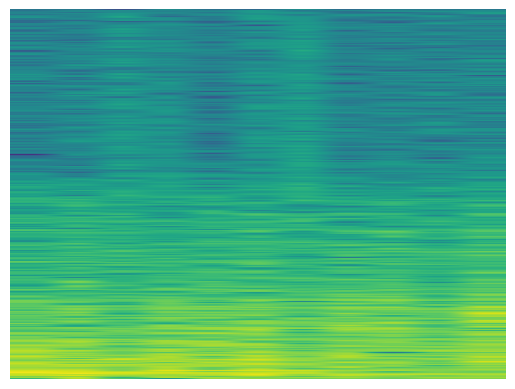

In [ ]:
generate_images(sch_specgram_data, os.path.join(images_path_a, 'sch'), start=10, end=35)

generated:  sub10-seg0


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-af4d817acc74>", line 1, in <cell line: 1>
    generate_images(norm_specgram_data, os.path.join(images_path_a, 'norm'), start=10, end=28)
  File "<ipython-input-12-f726807f3801>", line 17, in generate_images
    generate_images_for_subject(path, data[i], i)
  File "<ipython-input-12-f726807f3801>", line 8, in generate_images_for_subject
    create_spectrogram(segment, fs=freq, impath=os.path.join(path, filename), save=True)
  File "<ipython-input-6-41fc2b4dd3b7>", line 30, in create_spectrogram
    plt.savefig(impath, dpi=300, pad_inches=0.0, transparent=True, bbox_inches='tight')
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py", line 1023, in savefig
    res = fig.savefig(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/matplotlib/f

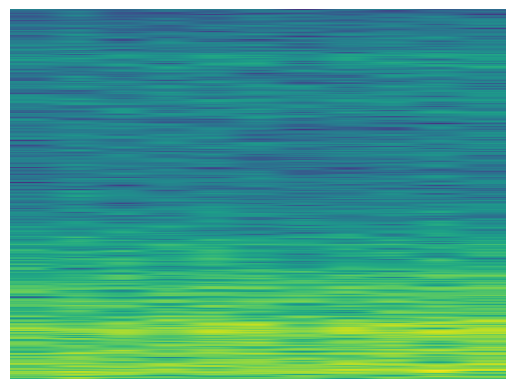

In [ ]:
generate_images(norm_specgram_data, os.path.join(images_path_a, 'norm'), start=10, end=28)